# Enhanced features for a Simple Warp Interface for Thermionic Converters

**5/10/2017**

This version of the original "Develop_Warp_Thermionic_Converter" notebook includes additional features for improving the GUI for electrostatic simulations.

These improvements include specific features for the simulation control palette in the visualization tab of the GUI:

1. Isolated code to quickly compute a converged electric potential for the user-defined grid
2. A script to computed an estimated "expected" time of flight for an electron across the gap.


5/10/2017

Nathan Cook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
del sys.argv[1:] #  Necessry to run 'from warp import *' in IPython notebook without conflict.
from warp import * 
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import h5py
from re import findall
from scipy.special import erfinv
from datetime import datetime

import rswarp
from warp.data_dumping.openpmd_diag import ParticleDiagnostic
from rswarp.diagnostics import FieldDiagnostic
from rswarp.utilities.file_utils import cleanupPrevious
from rswarp.utilities.file_utils import readparticles
from rswarp.utilities.file_utils import loadparticlefiles
from rswarp.cathode import sources
from rswarp.cathode import injectors

# Constants imports
from scipy.constants import e, m_e, c, k
kb_eV = 8.6173324e-5 #Bolztmann constant in eV/K
kb_J = k #Boltzmann constant in J/K
m = m_e

# Warp
# Origin date: Thu, 27 Apr 2017 22:31:05 +0000
# Local date: Thu, 27 Apr 2017 22:31:05 +0000
# Commit hash: 8d81829
# /Users/ncook/.virtualenvs/rswarp_env/lib/python2.7/site-packages/warp/warp.pyc
# /Users/ncook/.virtualenvs/rswarp_env/lib/python2.7/site-packages/warp/warpC.so
# Thu May 11 00:14:15 2017
# import warp time 0.246575117111 seconds
# For more help, type warphelp()


/Users/ncook/.virtualenvs/rswarp_env/lib/python2.7/site-packages/warp/warp.py:79: UserWarning: there was an error importing gist; if this is a problem, restart python and type 'import gist' for details, otherwise Warp will run OK but with no graphics
  warnings.warn("there was an error importing gist; if this is a problem, restart python and type 'import gist' for details, otherwise Warp will run OK but with no graphics")


## Diagnostics

In [3]:
diagDir = 'diags/xzsolver/hdf5/'
field_base_path = 'diags/fields/'
diagFDir = {'magnetic':'diags/fields/magnetic','electric':'diags/fields/electric'}

# Cleanup previous files
cleanupPrevious(diagDir,diagFDir)

## Grid parameters

The grid parameters comprise one of the primary sets of user inputs, and are required for initializing the grid, pre-calculating fundamental currents, and generating the solver. These values are also used throuhgout visualization scripts.

**'Physical' Grid Parameters. These are physically intuitive values for a simple domain specification:**

1. `PLATE_SPACING` - The longitudinal distance (z-axis) between cathode and anode
2. `CHANNEL_WIDTH` - The transverse dimension of the simulation domain


**Technical Grid Parameters. These provide the required inputs for constructing simulation objects, but may be computed from the physical parameters above for a simple rectangular geometry:**

1. `X_MIN, X_MAX` - By default, horizontal domain is `(-0.5*CHANNEL_WIDTH,0.5*CHANNEL_WIDTH)`
2. `X_MIN, X_MAX` - By default, longitudinal domian is `[0, PLATE_SPACING]`
3. `Y_MIN, Y_MAX` - The ignorable plane, but specified for completeness. Defaults to +/- `(-0.5*CHANNEL_WIDTH,0.5*CHANNEL_WIDTH)`
4. `NUM_X` - The number of grid points along x.
5. `NUM_Y` - The number of grid points along y (ignorable for 2DXZ geometry).
6. `NUM_Z` - The number of grid points along z.


In [4]:
#GLOBAL GEOMETRY PARAMETERS FOR USERS
PLATE_SPACING = 10e-6 #plate spacing
CHANNEL_WIDTH = 110e-9 #width of simulation box

#Dimensions
X_MAX = CHANNEL_WIDTH*0.5
X_MIN = -1.*X_MAX
Y_MAX = CHANNEL_WIDTH*0.5
Y_MIN = -1.*Y_MAX
Z_MIN = 0.
Z_MAX = PLATE_SPACING


#Grid parameters
NUM_X = 11
NUM_Y = 64
NUM_Z = 512

#z step size
dz =  (Z_MAX - Z_MIN)/NUM_Z

## Solver Geometry and Boundaries

The solver geometry is a fundemental pre-requisite for any interface or simulation setup. We will assume for now that we are fixing a 2D X-Z geometry, with the Y axis as an ignorable plane. 

**`w3d.solvergeom = w3d.XZgeom`**

Future extensions to the interface will support 3D geometries. Where applicable and simple, small code snippets have been included in anticipation of this feature. However by no means are these scripts fully compliant with 3D simulations.

In [5]:
#Specify solver geometry
w3d.solvergeom = w3d.XZgeom

assert w3d.solvergeom == w3d.XZgeom, \
        'Solver geometry required to be w3d.XZgeom'

# Set boundary conditions
# Longitudinal conditions overriden by conducting plates
w3d.bound0  = neumann
w3d.boundnz = dirichlet
w3d.boundxy = periodic 
# Particles boundary conditions
top.pbound0  = absorb
top.pboundnz = absorb
top.pboundxy = periodic

# Set grid boundaries
w3d.xmmin = X_MIN
w3d.xmmax = X_MAX
w3d.zmmin = 0. 
w3d.zmmax = Z_MAX

# Set grid counts
w3d.nx = NUM_X
w3d.nz = NUM_Z

zmesh = np.linspace(0,Z_MAX,NUM_Z+1) #holds the z-axis grid points in an array

## Source parameterization

This section covers source parameterization, in particular how the electrons are emitted from the cathode. Warp permits several options. We want to support three options. For simplicity, I've defined the `USER_INJECT` flag which corresponds to the three possible options:

1. Constant emission - user specifies current. `USER_INJECT = 1`
2. Child-Langmuir emission (computed from geometries) - user selects and current is computed and displayed `USER_INJECT = 2`
3. thermionic emission (computed from cathode temperature) - user selects and current is computed and displayed `USER_INJECT = 3`

**Note that the following USER PARAMETERS are needed for the essential specification of the beam:**

1. Instantiation via species command i.e. `beam = Species(type=Electron, name='beam')`
2. beam radii in x,y via a0, b0 (`beam.a0 = 0.5*BEAM_WIDTH`). In many cases, `BEAM_WIDTH = CHANNEL_WIDTH`.
3. beam current (`beam.ibeam = BEAM_CURRENT`)
4. Cathode temperature in Kelvin (`CATHODE_TEMP`). Should default to 4K.
5. Minimum z-coordinate for injected particles (`Z_PART_MIN`). Must have `Z_PART_MIN > Z_MIN`.


**The next set of parameters are generated from additional user parameters (grid, beam, etc.):**

1. The injection type for the instance of `top` (`top.inejct = 6`). This will be set to 6 (user injection) for most cases, determined by the `USER_INJECT` switch.
2. Number of particles to be injected per step (`top.npinject`). This is computed from grid parameters and defaults to 10 particles per horizontal cell(e.g. `10*NUM_X`).
2. Injection coordinate determination - analytical vs. interpolated (`w3d.l_inj_exact`). Defaults to false for most injection types.
3. Variance of thermal particle velocity distribution in z (`beam.vthz`). Defaults to 0.
4. Variance of thermal particle velocity distribution in transverse plane (`beam.vthperp`). Defaults to 0.


The `rswarp` repository has been updated with a cathode module to streamline the designation of cathode sources via each of these three methods. Below we will demonstrate their use and provide a simple template.

In [6]:
#Cathode and anode settings
CATHODE_TEMP = 1273.15 #1100. #1273.15 #1000. #cathode temperature in K
CATHODE_PHI = 2.0 #work function in eV
ANODE_WF = 0.1
GRID_BIAS = 0.4 #voltage applied to any grid of electrodes

vacuum_level = CATHODE_PHI - ANODE_WF + GRID_BIAS
    
#compute beam cutoff velocity for time-step determinance
beam_beta = sources.compute_cutoff_beta(CATHODE_TEMP)

#Compute Child-Langmuir limit for this setup A/m^2
cl_limit = sources.cl_limit(CATHODE_PHI, ANODE_WF, GRID_BIAS, PLATE_SPACING)

In [7]:
#INJECTION SPECIFICATION
USER_INJECT = 1

# --- Setup simulation species
beam = Species(type=Electron, name='beam')

# --- Set basic beam parameters
SOURCE_RADIUS_1 = 0.5*CHANNEL_WIDTH #a0 parameter - X plane
SOURCE_RADIUS_2 = 0.5*CHANNEL_WIDTH #b0 parameter - Y plane
Z_PART_MIN = dz/8. #starting particle z value


#Compute cathode area for geomtry-specific current calculations
if (w3d.solvergeom == w3d.XYZgeom):
    #For 3D cartesion geometry only
    cathode_area = 4.*SOURCE_RADIUS_1*SOURCE_RADIUS_2
else:
    #Assume 2D XZ geometry
    cathode_area = 2.*SOURCE_RADIUS_1*1. # 1 m is the geometric factor scaling the plane of the ignorable coordinate        
      
#Set a default 'USER_CURRENT' to the Richardson-Dushman current in case of user-specified constant emission
#This will ultimately be an adjustable GUI parameter.
USER_CURRENT = cl_limit*cathode_area #sources.j_rd(CATHODE_TEMP,CATHODE_PHI)*cathode_area 

# If true, position and angle of injected particle are computed analytically rather than interpolated
# Can be false for all but C-L injection (inject=2)
w3d.l_inj_exact = False 

#Specify particles to be injected each step - 10 macro-particles per cell by default, USER SPECIFIED IN FUTURE
PTCL_PER_STEP = 10*NUM_X
top.npinject = PTCL_PER_STEP

# --- If using the XZ geometry, set so injection uses the same geometry
top.linj_rectangle = (w3d.solvergeom == w3d.XZgeom)

#Determine an appropriate time step based upon estimated final velocity
vzfinal = sqrt(2.*abs(vacuum_level)*np.abs(beam.charge)/beam.mass)+beam_beta*c
dt = dz/vzfinal #5e-15
top.dt = dt

if vzfinal*top.dt > dz:
    print "Time step dt = {:.3e}s does not constrain motion to a single cell".format(top.dt)


if USER_INJECT == 1:
    # Constant current density - beam transverse velocity fixed to zero, very small longitduinal velocity
    
    #Set injection flag
    top.inject = 6               # 1 means constant; 2 means space-charge limited injection;# 6 means user-specified
    
    beam.ibeam = USER_CURRENT
    beam.a0     = SOURCE_RADIUS_1
    beam.b0     = SOURCE_RADIUS_2
    
    #sources.constant_current(beam, CHANNEL_WIDTH, Z_PART_MIN, ptcl_per_step)
    myInjector = injectors.injectorUserDefined(beam, CATHODE_TEMP, CHANNEL_WIDTH, Z_PART_MIN, PTCL_PER_STEP)
    installuserinjection(myInjector.inject_constant)
    
if USER_INJECT == 2:
    # space charge limited injection using Child-Langmuir computation of cold limit

    #Set injection flag
    top.inject = 2               # 1 means constant; 2 means space-charge limited injection;# 6 means user-specified
    
    beam_current = sources.cl_limit(CATHODE_PHI, ANODE_WF, GRID_BIAS, PLATE_SPACING)*cathode_area
    
    
    beam.ibeam = beam_current
    beam.a0     = SOURCE_RADIUS_1
    beam.b0     = SOURCE_RADIUS_2    
    w3d.l_inj_exact = True

    
elif USER_INJECT == 3:
    #Thermionic injection
    
    #Set injection flag
    top.inject = 6               # 1 means constant; 2 means space-charge limited injection;# 6 means user-specified   

    beam_current = sources.j_rd(CATHODE_TEMP,CATHODE_PHI)*cathode_area #steady state current in Amps
    beam.ibeam = beam_current
    beam.a0     = SOURCE_RADIUS_1
    beam.b0     = SOURCE_RADIUS_2
    
    myInjector = injectors.injectorUserDefined(beam, CATHODE_TEMP, CHANNEL_WIDTH, Z_PART_MIN, PTCL_PER_STEP)
    installuserinjection(myInjector.inject_thermionic)
    
    # These must be set for user injection
    top.ainject = 1.0          
    top.binject = 1.0


derivqty()

## Create solver

In [8]:
# Set up fieldsolver
f3d.mgtol = 1e-6 # Multigrid solver convergence tolerance, in volts. 1 uV is default in Warp.
solverE = MultiGrid2D()
registersolver(solverE)

## Install conductors

In [9]:
# --- Emitter settings
extractor_voltage = vacuum_level
# --- Anode Location
zplate = Z_MAX#1e-6 # --- plate location

# Create source conductors
source = ZPlane(zcent=w3d.zmmin,zsign=-1.,voltage=0.)
installconductor(source, dfill=largepos)

# Create ground plate
plate = ZPlane(voltage=extractor_voltage, zcent=zplate)
installconductor(plate,dfill=largepos)

# Setup the particle scraper
scraper = ParticleScraper([source, plate])

## Define diagnostics

In [10]:
particleperiod = 100
particle_diagnostic_0 = ParticleDiagnostic(period = particleperiod, top = top, w3d = w3d,
                                          species = {species.name: species for species in listofallspecies},
                                          comm_world=comm_world, lparallel_output=False, write_dir = diagDir[:-5])
fieldperiod = 100
efield_diagnostic_0 = FieldDiagnostic.ElectrostaticFields(solver=solverE, top=top, w3d=w3d, comm_world = comm_world,
                                                          period=fieldperiod)

installafterstep(particle_diagnostic_0.write)
installafterstep(efield_diagnostic_0.write)

## UPDATED - Generate simulation package and plot potential

This call has been updated to allow for plotting of the electrostatic potential. Rather than calling generate with its default parameters, the `mgmaxiters` parameter is set to a large value (11000) to allow the initial solve called by generate to produce a potential that has converged to the geometry. After the `generate()` is finished, the parameter is reset to its default of 100.

In [11]:
#prevent GIST from starting upon setup
top.lprntpara = false
top.lpsplots = false

top.verbosity = 0 # Reduce solver verbosity 
solverE.mgverbose = 0 #further reduce output upon stepping - prevents websocket timeouts in Jupyter notebook

#Adjusting the multigrid parameter here improves convergence speed
omega = 2./(1. + np.sin(np.pi/min(NUM_X+1,NUM_Z+1)))
solverE.mgparam = omega

solverE.mgmaxiters = 12000 #rough approximation needed for initial solve to converge
package("w3d")
generate()
solverE.mgmaxiters = 100

 ***  particle simulation package W3D generating
 ---  Resetting lattice array sizes
 ---  Allocating space for particles
 ---  Loading particles
 ---  Setting charge density
 ---  done
 ---  Allocating Win_Moments
 ---  Allocating Z_Moments
 ---  Allocating Lab_Moments
Multigrid2d: Max. # of iterations reached
Multigrid2d: Error converged to   6.663E-06 in 12000 v-cycles           


### UPDATED - Now plot the potential

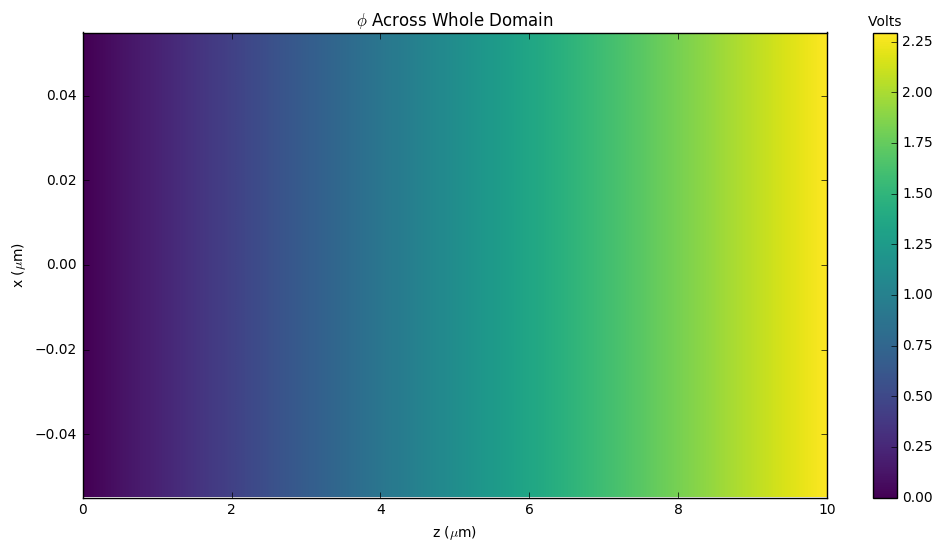

In [12]:
#Need to compute the potential first
potential = solverE.getphi()

#Now plot
fig = plt.figure(figsize=(12,6))

X_CELLS = NUM_X
Z_CELLS = NUM_Z

potential = solverE.getphi()

xl = 0
xu = NUM_X
zl = 0 
zu = NUM_Z 

midpoint = 1 - np.max(potential[xl:xu,zl:zu])/(np.max(potential[xl:xu,zl:zu]) + 
                                             abs(np.min(potential[xl:xu,zl:zu])))

plt.xlabel("z ($\mu$m)")
plt.ylabel("x ($\mu$m)")
plt.title("$\phi$ Across Whole Domain")

pxmin = ((X_MAX - X_MIN) / X_CELLS * xl + X_MIN) * 1e6
pxmax = ((X_MAX - X_MIN) / X_CELLS * xu + X_MIN) * 1e6
pzmin = (Z_MIN + zl / Z_CELLS * Z_MAX) * 1e6
pzmax = (Z_MAX * zu / Z_CELLS) * 1e6

plt.xlim(pzmin, pzmax)
plt.ylim(pxmin, pxmax)

phi_plt = plt.imshow(potential[xl:xu,zl:zu],cmap='viridis',extent=[pzmin, pzmax, pxmin, pxmax],aspect='auto')

cbar = fig.colorbar(phi_plt)
cbar.ax.set_xlabel("Volts")
cbar.ax.xaxis.set_label_position('top')

#plt.show()

### Estimate the time of flight for an electron crossing the gap

We will estimate the average time of flight for a particle by averaging over the x-plane of the electric field, then integrating the particle motion in that averaged electric field. For our simulation particle we will take an electron with the expected velocity based on a thermal distribution with the cathode temperature.

**Note that this requires importing the interp1d function from scipy.interpolate**

In [14]:
from scipy.interpolate import interp1d as scipy_interp1d

#Grab Ez from the solver and average over the transverse (x) plane
Ez = solverE.getez()
flat_Ez = numpy.mean(Ez,0)

#Generate an interpolating function for smooth particle integration
Ez_approx = scipy_interp1d(zmesh,flat_Ez, kind='cubic')

#Integrate the particle motion subject to initial conditions specified by the simulation
tof_expected = sources.compute_expected_time(beam, CATHODE_TEMP, Ez_approx, Z_MIN, Z_MAX, top.dt)

print "Expected time of flight is {}s".format(tof_expected)
print "This corresponds to {} steps".format(tof_expected/top.dt)

Expected time of flight is 1.95578558527e-11s
This corresponds to 1259.0 steps


## Run simulation

In [14]:
#%%time
num_steps = 5000
output_steps = np.linspace(0,num_steps,num_steps/particleperiod + 1)[1:]
step_count = 0
time0 = time.time()
step(num_steps)
time1 = time.time()
time_per_step = (time1-time0)/num_steps

 ***  particle simulation package W3D running


## Some basic diagnostics

A few diagnostics for testing. Specifically, we look at the current across the gap at the end of the simulation to verify that it's uniform at the value expected.

In [15]:
efield_path = diagFDir['electric']
efield_files = [os.path.join(efield_path,fn) for fn in os.listdir(efield_path)]
efield_files.sort()

fielddata_file = efield_files[-1]
step_number = int(findall(r'\d+', fielddata_file)[0])
data_efield = h5py.File(fielddata_file, 'r')

Ex = data_efield['data/%s/meshes/E/x' % (step_number)]
Ey = data_efield['data/%s/meshes/E/y' % (step_number)]
Ez = data_efield['data/%s/meshes/E/z' % (step_number)]

phi = data_efield['data/%s/meshes/phi'% (step_number)]

particles_path = diagDir
particles_files = [os.path.join(particles_path,fn) for fn in os.listdir(particles_path)]
particles_files.sort()

particledata_file = particles_files[-1]

# Read single particle diagnostic file in
f0 = readparticles(particledata_file.format(num_steps))
# Read all particles into directory. Structure: name[int stepnumber][str Species name]
fall = loadparticlefiles(particles_path)

In [16]:
def get_zcurrent_new(particle_array, momenta, mesh, particle_weight, dz):
    """
    Find z-directed current on a per cell basis
    particle_array: z positions at a given step
    momenta: particle momenta at a given step in SI units
    mesh: Array of Mesh spacings
    particle_weight: Weight from Warp
    dz: Cell Size
    """    

    charge = 1.60217662e-19
    mass = 9.10938356e-31
    current = np.zeros_like(mesh)
    velocity = c * momenta / np.sqrt(momenta**2 + (mass * c)**2)

    for index, zval in enumerate(particle_array):
        bucket = np.round(zval/dz) #value of the bucket/index in the current array
        current[int(bucket)] += velocity[index]
        
    return current* charge * particle_weight / dz

In [17]:
# Get current for all steps (takes a long time)
current_history = []
for i in range(particleperiod,num_steps,particleperiod):
    #print i
    curr = get_zcurrent_new(fall[i]['beam'][:,4],fall[i]['beam'][:,5],zmesh,beam.sw,dz)
    current_history.append(curr)

current_history = np.asarray(current_history)

<IPython.core.display.Javascript object>


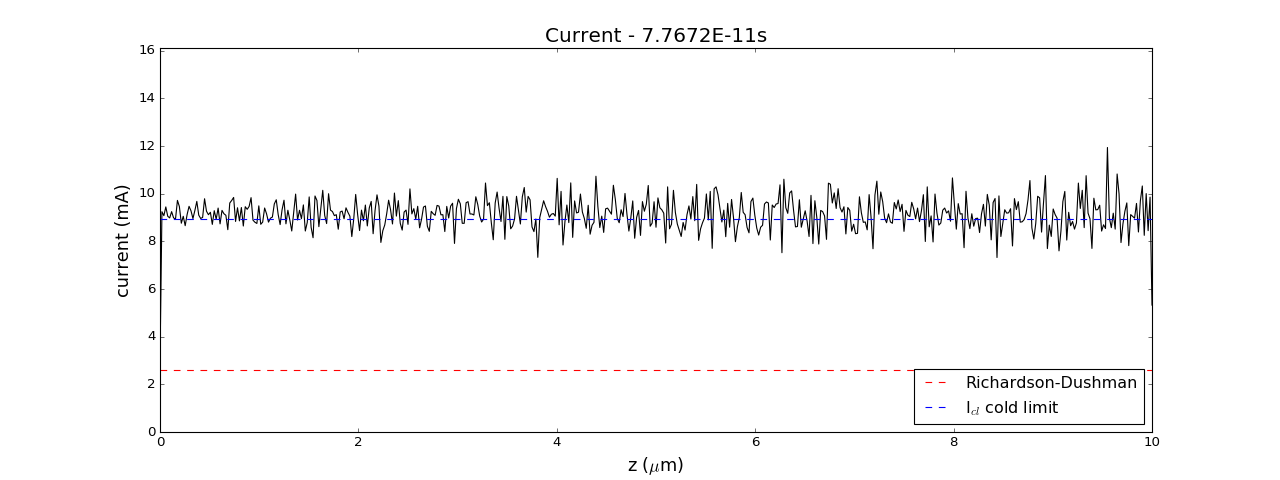

In [18]:
#Plot the current across gap at a single time
fig5 = plt.figure(figsize=(16,6))

#scalings
h_scale = 1.e6
y_range_max = beam.ibeam*1.e3*1.2

#current plotted from grid
plt.plot(zmesh*h_scale,np.array(current_history[-1])*1e3,'k')

#Compute and plot idealized currents as needed
RD_ideal = np.ones(len(zmesh))*sources.j_rd(CATHODE_TEMP,CATHODE_PHI)*cathode_area
JCL_ideal = np.ones(len(zmesh))*cl_limit*cathode_area

if (RD_ideal[0]*1e3 <= y_range_max):
    plt.plot(zmesh*h_scale,RD_ideal*1.e3,'r--',label=r'Richardson-Dushman')

if (JCL_ideal[0]*1e3 <= y_range_max):
    plt.plot(zmesh*h_scale,JCL_ideal*1.e3,'b--',label=r'I$_{cl}$ cold limit')

#labels and legends
plt.xlabel("z ($\mu$m)",fontsize='16')
plt.ylabel("current (mA)",fontsize='16')
plt.title("Current - {:.4E}s".format(fall[num_steps]['time']),fontsize=18)
plt.xlim(Z_MIN,Z_MAX*1.e6)
plt.ylim(0, y_range_max)

plt.legend(loc=4)
title = 'current_{:.4f}ps-test.pdf'.format(CATHODE_TEMP,fall[num_steps]['time']*1.e9)
#fig5.savefig(title,bbox_inches='tight')